In [15]:
# First we import a bunch of libraries
import pandas as pd
import numpy as np
import folium # map visualisation package
import requests # this we use for API calls
import json
import matplotlib.pyplot as plt
import branca.colormap as cm
from dateutil import tz
import datetime
import time
from tqdm import tqdm

# Then we load the data
df = pd.read_csv("test.csv")
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,T1,B,NaN,15.0,20000542,1408039037,A,False,"[[-8.585676,41.148522],[-8.585712,41.148639],[..."
1,T2,B,NaN,57.0,20000108,1408038611,A,False,"[[-8.610876,41.14557],[-8.610858,41.145579],[-..."
2,T3,B,NaN,15.0,20000370,1408038568,A,False,"[[-8.585739,41.148558],[-8.58573,41.148828],[-..."
3,T4,B,NaN,53.0,20000492,1408039090,A,False,"[[-8.613963,41.141169],[-8.614125,41.141124],[..."
4,T5,B,NaN,18.0,20000621,1408039177,A,False,"[[-8.619903,41.148036],[-8.619894,41.148036]]"


In [16]:
df.shape
(1710670, 9)

(1710670, 9)

In [17]:
api_key = "enQ7N4ctq0YRWahGcAli1YBlg9bmAvdB"

# Initiate the map with the TomTom maps API
def initialise_map(api_key=api_key, location=[41.161178, -8.648490], zoom=14, style = "main"):
    """
    The initialise_map function initialises a clean TomTom map
    """
    maps_url = "http://{s}.api.tomtom.com/map/1/tile/basic/"+style+"/{z}/{x}/{y}.png?tileSize=512&key="
    TomTom_map = folium.Map(
    location = location, # on what coordinates [lat, lon] we want to initialise our map
    zoom_start = zoom, # with what zoom level we want to initialise our map, from 0 to 22
    tiles = str(maps_url + api_key),
    attr = 'TomTom')
    return TomTom_map

# Save map as TomTom_map
TomTom_map = initialise_map()
TomTom_map

In [18]:
def polyline_to_list(polyline):
    """
    The polyline_to_list_lists function transforms the raw polyline to a list of tuples
    input: '[[-8.639847,41.159826],[-8.640351,41.159871]'
    output: [[41.159826, -8.639847],[41.159871, -8.640351]]
    """
    trip = json.loads(polyline) # json.loads converts the string to a list
    coordinates_list = [list(reversed(coordinates)) for coordinates in trip]
    # transform list (reverse values and put it in a list of lists)
    return coordinates_list

# Plot polyline on the map
polyline = polyline_to_list(df['POLYLINE'][1])
folium.PolyLine(polyline).add_to(TomTom_map)
TomTom_map

In [24]:
def convertUnixTimeToDate(timestamp):
    """
    The convertUnixTimeToDate function transforms a UNIX timestamp to a ISO861 dateTime format
    for a date in the future
    input: 1372636858
    output: '2024-05-3T00:00:58Z'
    """

    # Portugal is in UTC+0 time zone, first get the right time zone:
    UTC = tz.gettz('UTC')

    # Then convert our timestamp to the right format:
    timeTrip = datetime.datetime.fromtimestamp(timestamp,tz=UTC)
    weekday = timeTrip.strftime("%A") # get day of the week
    timeofday = timeTrip.strftime("%H:%M:%SZ") # get time of the day

    # Some hardcoded weekday dates in the future. Not the most elegant solution but fast:
    convertWeekdays = {
        "Monday":"2024-05-3T",
        "Tuesday":"2024-05-4T",
        "Wednesday":"2024-05-5T",
        "Thursday":"2024-05-6T",
        "Friday":"2024-05-7T",
        "Saturday":"2024-05-8T",
        "Sunday":"2024-05-9T"}

    routingTime = convertWeekdays[weekday] + timeofday

    return routingTime

def call_routing_api(polyline, departure_time, api_key=api_key, taxi_route=True):
    """
    Input is a polyline of a taxi route, a UNIX departure time, and whether to get the results for the taxi
    route or fastest route
    Output is the traffic delay in seconds, travel time of the route, route points from the Routing API and
    the full response from the API
    """

    coordinates_list = polyline_to_list(polyline) # transform polyline to list of tuples

    lat1, lon1 = coordinates_list[0] # origin coordinates of the trip
    lat2, lon2 = coordinates_list[-1] # destination coordinates of the trip

    # Set the URL for the Routing API
    routing_url = "https://api.tomtom.com/routing/1/calculateRoute/"
    url = str(routing_url + str(lat1) + ',' + str(lon1) + ':' + str(lat2) + ',' + str(lon2) +
    "/json?maxAlternatives=0&departAt=" + convertUnixTimeToDate(departure_time) +
    "&traffic=true&key=" + api_key)

    # Add support points for the route reconstruction:
    body = {"supportingPoints": []}

    if taxi_route == True:
        support_points = polyline_to_list(polyline) # use the whole polyline
        for point in support_points:
            body["supportingPoints"].append({"latitude": point[0],"longitude": point[1]})
    else:
        support_points = polyline_to_list(polyline)[-1] # use only the final coordinate
        body["supportingPoints"].append({"latitude": support_points[0],"longitude": support_points[1]})

    # Send the API call to TomTom:
    n = 0
    while True:
        n+=1
        try:
            response = requests.post(url,json=body)

            # Call was succesful"
            if response.status_code == 200:
                break

            # Call broke QPS limit, sleep for one second:
            elif response.status_code == 403:
                time.sleep(1)
        except:
            print("error", str(response.status_code))

        # Stop after 4 attempts:
        if n > 4:
            break
    # Return None if the call was not succesful
    if response.status_code == 200:
        response = response.json()

        delay = response['routes'][0]["summary"]['trafficDelayInSeconds']
        travel_time = response['routes'][0]["summary"]['travelTimeInSeconds']
        points = response['routes'][0]['legs'][0]['points']
        route_points = [[point['latitude'], point['longitude']] for point in points]

        return delay, travel_time, route_points, response
    else:
        return None, None, None, None
    
    
delay_taxi, travel_time_taxi, route_points_taxi, response_taxi = call_routing_api(df['POLYLINE'][1], df['TIMESTAMP'][1], taxi_route=True)

print("The taxi route will take you:", travel_time_taxi, 'seconds')

# Next we calculate the travel time and route for the fastest route:
delay_fastest, travel_time_fastest, route_points_fastest, response_fastest = call_routing_api(df['POLYLINE'][1], df['TIMESTAMP'][1], taxi_route=False)

print("The fastest route will take you:", travel_time_fastest, 'seconds')

TomTom_map = initialise_map(location=[41.164962,-8.656301], zoom=15)

# Plot the points of the original route on the map
polyline = polyline_to_list(df['POLYLINE'][1])
folium.PolyLine(polyline, color="blue", weight=2, opacity=1).add_to(TomTom_map)

# Plot the points of the original reconstructed route on the map
folium.PolyLine(route_points_taxi, color="black", weight=2, opacity=1).add_to(TomTom_map)

# Plot fastest route on the map
folium.PolyLine(route_points_fastest, color="red", weight=2, opacity=1).add_to(TomTom_map)

TomTom_map


The taxi route will take you: 702 seconds
The fastest route will take you: 702 seconds


In [34]:
random_sample = df.sample(300, random_state=123)#CHANGED FROM 1200, ONLY 321 RECORDS EXIST
random_sample = random_sample.reset_index().drop('index', axis=1) # reset index so we can iterate

# initialise dictionary in which we will store our results
results = {"Fastest_traveltime": [], "Taxi_traveltime": [],"Polyline" :[]}
# For each polyline in random_sample, call the call_routing_api function twice, once to retrieve the travel time
# for the fastest route and once for the travel time of the taxi route

for i in tqdm( range(len(random_sample)) ):
    if random_sample['POLYLINE'][i] != '[]': # check if polyline is not empty
        
    # travel time fastest route
        results['Fastest_traveltime'].append(
            call_routing_api(random_sample['POLYLINE'][i], random_sample['TIMESTAMP'][i], taxi_route=False)[1])

        # travel time taxi route
        results['Taxi_traveltime'].append(
            call_routing_api(random_sample['POLYLINE'][i], random_sample['TIMESTAMP'][i], taxi_route=True)[1])

        # add departurePoint to results:
        polyline = polyline_to_list(random_sample['POLYLINE'][i])
        results['Polyline'].append(polyline)

100%|██████████| 300/300 [02:13<00:00,  2.25it/s]


In [35]:
results = pd.DataFrame(results)

# calculate the difference in minutes between the two routes
results['Difference_min'] = (results['Taxi_traveltime'] - results['Fastest_traveltime']) / 60

# calculate the relative difference between the two routes
results['Relative_diff'] = (results['Taxi_traveltime'] - results['Fastest_traveltime']) / results['Fastest_traveltime']

# keep only the trips that are long enough to make a proper comparison
results = results[results['Fastest_traveltime'] > 60] # trips should take at least 1 minute

# display dataframe
results.head()

,Fastest_traveltime,Taxi_traveltime,Polyline,Difference_min,Relative_diff
1,416,441,"[[41.148603, -8.585694], [41.148684, -8.585757...",0.416667,0.060096
2,804,2552,"[[41.151303, -8.609589], [41.151582, -8.609625...",29.133333,2.174129
3,759,1080,"[[41.180418, -8.582508], [41.180499, -8.582445...",5.350000,0.422925
5,87,876,"[[41.175477, -8.656344], [41.175486, -8.656317...",13.150000,9.068966
6,416,429,"[[41.165181, -8.642394], [41.165352, -8.643699...",0.216667,0.031250


In [36]:
print("Maximum relative difference is", round(max(results['Relative_diff']), 2))


Maximum relative difference is 9.45


In [37]:
results = results[results['Relative_diff'] < 2]


In [38]:
print("Mean:", np.mean(results['Difference_min']))
print("Standard deviation:", np.std(results['Difference_min']))


Mean: 1.8024253731343285
Standard deviation: 3.9732547151333844


Text(0, 0.5, 'Counts')

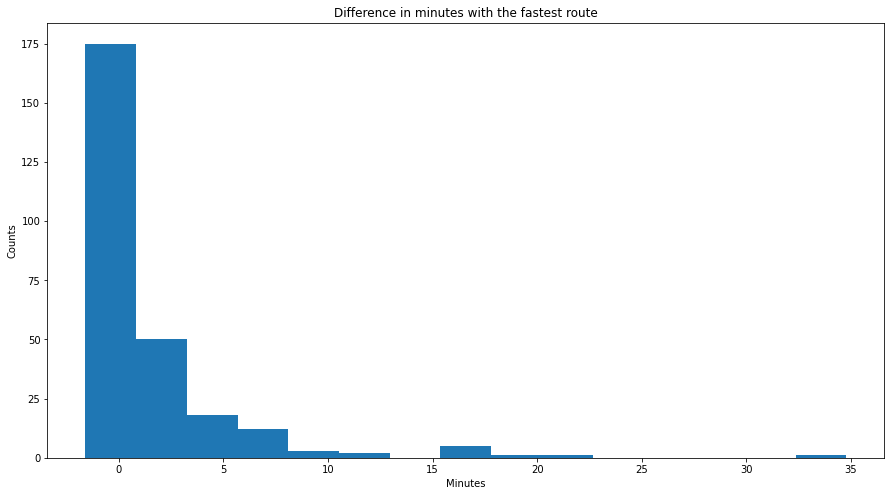

In [39]:
# Plot histogram
difference_min = sorted(np.array(results['Difference_min']))
fig = plt.figure(figsize=(15,8))
plt.hist(difference_min, bins=15)
plt.title("Difference in minutes with the fastest route")
plt.xlabel("Minutes")
plt.ylabel('Counts')

In [41]:
linear_color = cm.LinearColormap(['green', 'yellow', 'red'], vmin=0, vmax=0.5)
linear_color

TomTom_map_bubble = initialise_map(api_key=api_key, location=[41.161178, -8.648490], zoom=13, style = "night")

for index, row in results[:1000].iterrows(): # limit number of data points plotted to 1000

	popup_string = "Relative delay = " + str(round(100* row["Relative_diff"], 1)) + "%"

	folium.Circle(
	  location = row["Polyline"][0],
	  popup= popup_string,
	  radius=30,
	  color=linear_color(row["Relative_diff"]), #get_color(row["Relative_diff"]),
	  fill=True,
	  ).add_to(TomTom_map_bubble)

TomTom_map_bubble

In [42]:
# On this map we visualize all the polylines of the taxi trips using the same color scheme
TomTom_map_lines = initialise_map(api_key=api_key, location=[41.161178, -8.648490], zoom=13, style = "night")
for index, row in results[:500].iterrows(): # limit number of polylines plotted to 500

    folium.PolyLine(row["Polyline"],
        color=linear_color(row["Relative_diff"]),
		weight=1.0,
		opacity=1.5
		).add_to(TomTom_map_lines)

TomTom_map_lines